In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from helper_functions import walk_through_dir

BATCH_SIZE = 32
TARGET_SIZE = (96, 96)

def should_ignore(path, ignored_paths):
    return any(ignored_path in path for ignored_path in ignored_paths)

ignored_paths = ['LOONEY BIRDS', 'TURKEY', 'PENGUIN', 'OWL', 'EAGLE', 'EMU',
                 'VULTURE', 'CHICKEN', 'GOOSE', 'OSTRICH', 'CONDOR', 'PELICAN',
                'CASSOWARY', 'FLAMINGO', "CRANE", "SWAN", "PEACOCK", "IBIS",
                 "STORK", "PHEASANT", "FALCON", "OSPREY", "HAWK", "CURASSOW",
                 "VULTURINE", "HEN", "HUMMINGBIRD", "SWALLOW", "WARBLER", "FLYCATCHER",
                 "KINGFISHER", "HERON", "EGRET", "KINGLET", "SHRIKE", "WREN", "ABBOTTS BOOBY"]


dataset = "C:/colab/data/birds/train"
walk_through_dir(dataset);
image_dir = Path(dataset)
filepaths = [str(path) for path in image_dir.glob('**/*') if path.is_file() and not should_ignore(str(path), ignored_paths)]
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
train_df = pd.concat([filepaths, labels], axis=1)

dataset = "C:/colab/data/birds/test"
walk_through_dir(dataset);
image_dir = Path(dataset)
filepaths = [str(path) for path in image_dir.glob('**/*') if path.is_file() and not should_ignore(str(path), ignored_paths)]
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
test_df = pd.concat([filepaths, labels], axis=1)

dataset = "C:/colab/data/birds/valid"
walk_through_dir(dataset);
image_dir = Path(dataset)
filepaths = [str(path) for path in image_dir.glob('**/*') if path.is_file() and not should_ignore(str(path), ignored_paths)]
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
valid_df = pd.concat([filepaths, labels], axis=1)

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    interpolation='bilinear',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_images = test_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepath',
    y_col='Label',
    interpolation='bilinear',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    interpolation='bilinear',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [7]:

model = tf.keras.models.load_model('C:/colab/data/birds/saved_model/saved_model')
print("Params:", model.count_params())


Params: 146809


In [10]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Accuracy: {:.2f}%".format(results[1] * 100))

results = model.evaluate(val_images, verbose=0)

print("Val Loss: {:.5f}".format(results[0]))
print("Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.41596
Accuracy: 89.12%
Val Loss: 0.50685
Accuracy: 87.32%


65/65 [==============================] - 2s 21ms/step
The first 5 predictions: ['BAND TAILED GUAN', 'HIMALAYAN BLUETAIL', 'ABBOTTS BABBLER', 'BAND TAILED GUAN', 'ABBOTTS BABBLER']


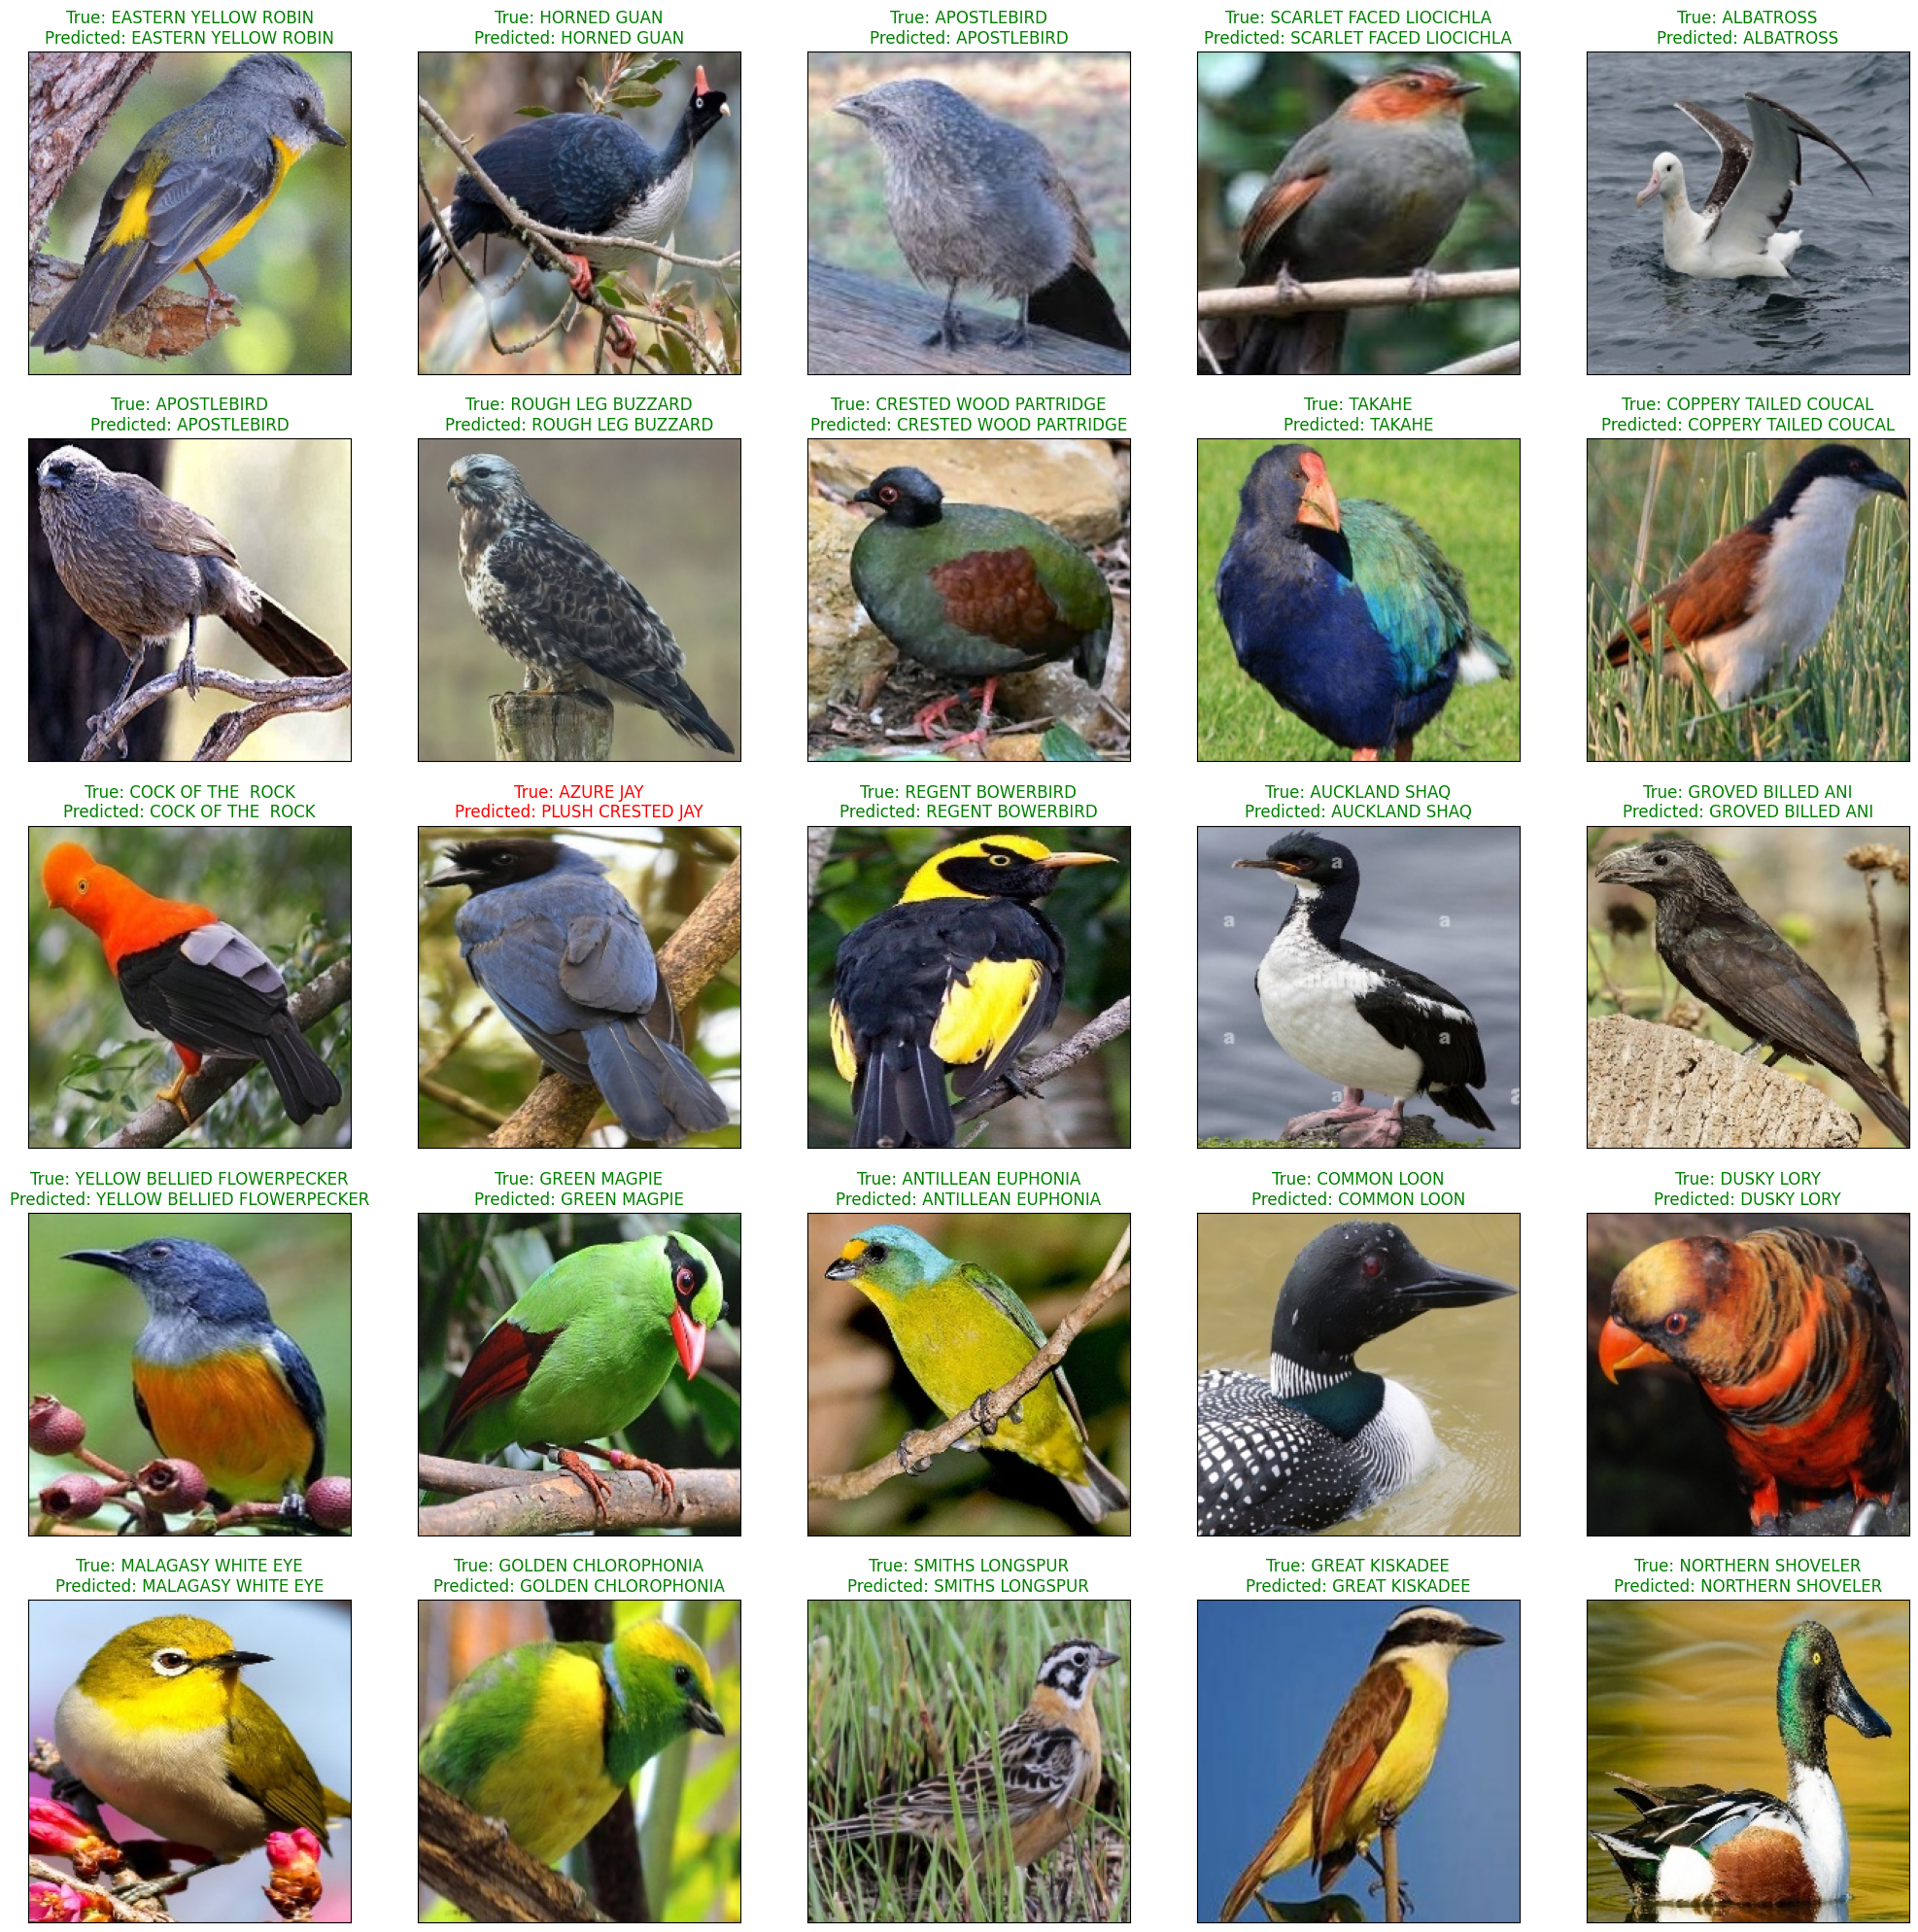

<Figure size 640x480 with 0 Axes>

In [11]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (test_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 25),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [12]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                               precision    recall  f1-score   support

              ABBOTTS BABBLER       1.00      0.40      0.57         5
   ABYSSINIAN GROUND HORNBILL       0.80      0.80      0.80         5
       AFRICAN EMERALD CUCKOO       0.83      1.00      0.91         5
            AFRICAN FIREFINCH       1.00      1.00      1.00         5
       AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
        AFRICAN PIED HORNBILL       1.00      0.80      0.89         5
                    ALBATROSS       1.00      0.80      0.89         5
               ALBERTS TOWHEE       0.83      1.00      0.91         5
         ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
                ALPINE CHOUGH       1.00      0.80      0.89         5
        ALTAMIRA YELLOWTHROAT       1.00      0.60      0.75         5
              AMERICAN AVOCET       1.00      0.80      0.89         5
             AMERICAN BITTERN       0.60      0.60      0.60         5
     

In [17]:
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


last_conv_layer_name = "conv_s2"
img_size = (96,96, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

C:\Users\Osenin\AppData\Local\Temp\ipykernel_12616\4281375209.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


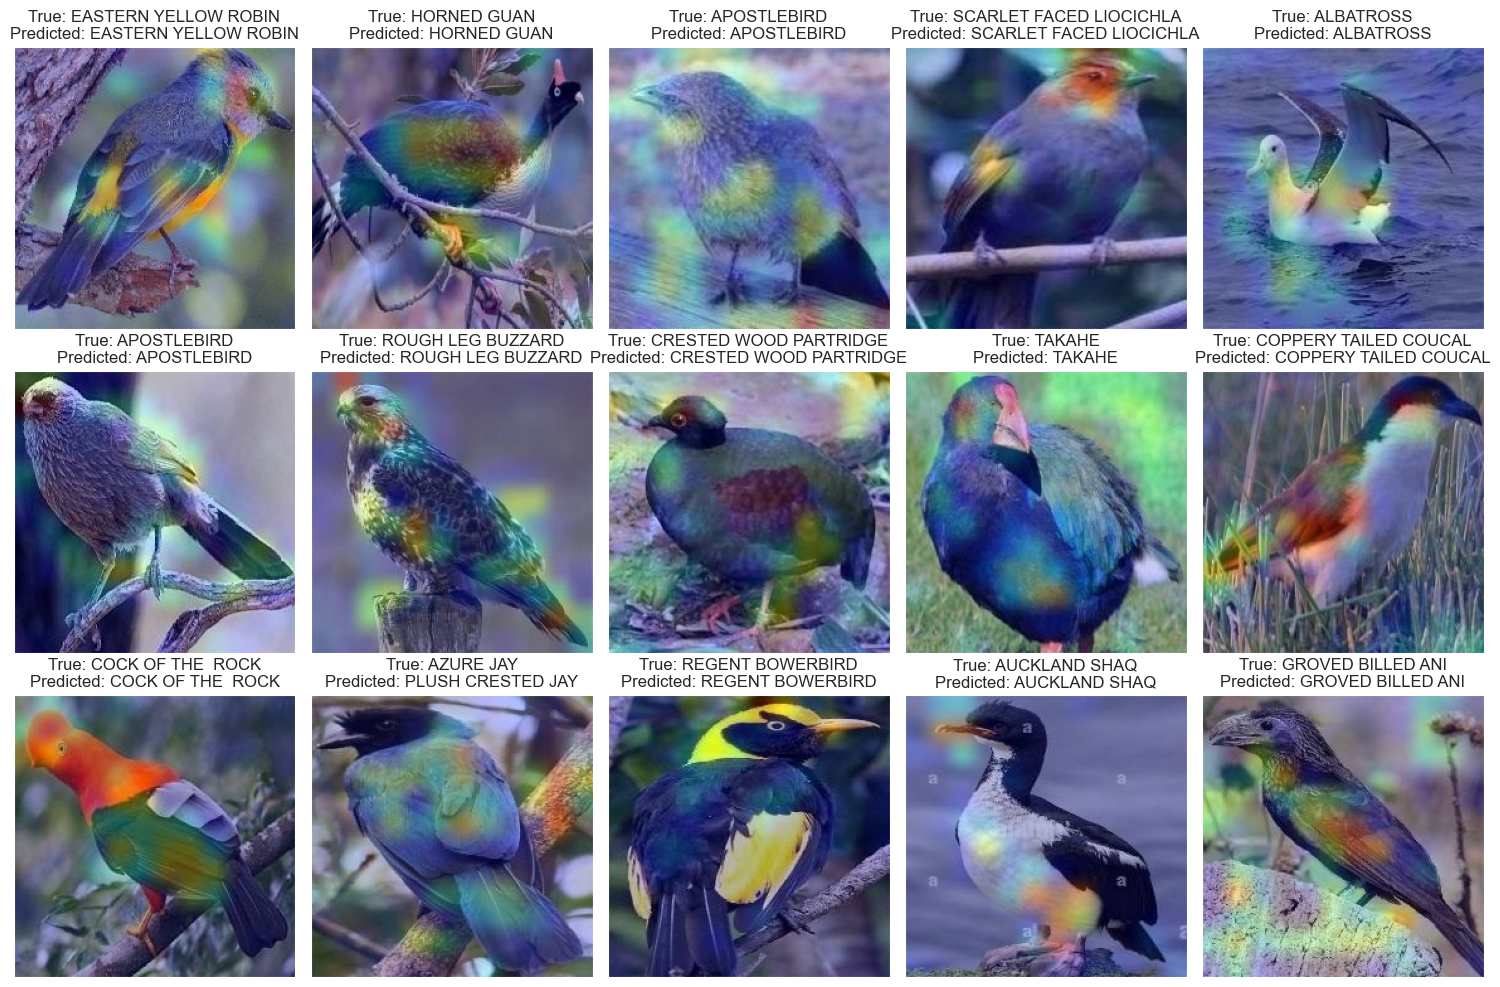

In [18]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = tf.keras.applications.efficientnet.preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

In [20]:
print("Starting model testing")
model_path = 'C:/colab/data/birds/bird_classifier-96-x-84-86.tflite'
tflite_interpreter = tf.lite.Interpreter(model_path=model_path)
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 96, 96, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter.allocate_tensors()

model_size_bytes = os.path.getsize(model_path)

  
print(f"Model Size: {model_size_bytes} bytes")

input_batch, _ = next(test_images)


results = []

for i in range(len(test_images)):
    batch = test_images[i]
    input_batch, labels = batch
    image_input_batch = tf.cast(input_batch, tf.int8)

    input_scale, input_zero_point = input_details[0]["quantization"]
    image_input_batch = tf.cast(image_input_batch, tf.float32)
    image_input_batch = (image_input_batch / input_scale) + input_zero_point
    image_input_batch = tf.cast(image_input_batch, tf.int8)

    if len(image_input_batch) == 32:
        tflite_interpreter.set_tensor(input_details[0]['index'], image_input_batch)
        tflite_interpreter.invoke()
        tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    
        tflite_predicted_ids = np.argmax(tflite_model_predictions, axis=-1)
        tflite_label_id = np.argmax(labels, axis=-1)
    
        correct_predictions = np.sum(tflite_predicted_ids == tflite_label_id)
        total_predictions = len(tflite_predicted_ids)
        accuracy_percentage = (correct_predictions / total_predictions) * 100
    
        results.append(accuracy_percentage)
        average_accuracy = sum(results) / len(results)
        print("\nIteration ", i, ": ", accuracy_percentage, " - Running Average: ", average_accuracy)

print("\nEnd Average: ", average_accuracy)

Starting model testing
Model Size: 227240 bytes

Iteration  0 :  81.25  - Running Average:  81.25

Iteration  1 :  62.5  - Running Average:  71.875

Iteration  2 :  78.125  - Running Average:  73.95833333333333

Iteration  3 :  78.125  - Running Average:  75.0

Iteration  4 :  78.125  - Running Average:  75.625

Iteration  5 :  90.625  - Running Average:  78.125

Iteration  6 :  87.5  - Running Average:  79.46428571428571

Iteration  7 :  78.125  - Running Average:  79.296875

Iteration  8 :  81.25  - Running Average:  79.51388888888889

Iteration  9 :  81.25  - Running Average:  79.6875

Iteration  10 :  90.625  - Running Average:  80.68181818181819

Iteration  11 :  81.25  - Running Average:  80.72916666666667

Iteration  12 :  75.0  - Running Average:  80.28846153846153

Iteration  13 :  68.75  - Running Average:  79.46428571428571

Iteration  14 :  78.125  - Running Average:  79.375

Iteration  15 :  81.25  - Running Average:  79.4921875

Iteration  16 :  100.0  - Running Average: 

In [23]:
model_h_path = "C:/colab/data/birds/model.h"

with open(model_path, "rb") as tflite_file:
    model_data = tflite_file.read()
    model_hex_array = ', '.join(f'0x{byte:02X}' for byte in model_data)


with open(model_h_path, "w") as model_h_file:
    model_h_file.write(f"const unsigned char model[] __attribute__((aligned(4))) = {{\n    {model_hex_array}\n}};\n")


model_h_size = os.path.getsize(model_h_path)
print(f"Header file, model.h, is {model_h_size:,} bytes.")


Header file, model.h, is 1,363,509 bytes.


In [24]:
import csv

def generate_c_function(csv_file_path, output_file_path):
    # Load labels from CSV
    labels = {}
    with open(csv_file_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            labels[int(row['ClassIndex'])] = row['Label']

    # Generate C function
    c_function = "#include <stdio.h>\n\n"
    c_function += "const char* getBirdLabel(int classIndex) {\n"
    c_function += "    switch(classIndex) {\n"

    for class_index, label in labels.items():
        c_function += f"        case {class_index}: return \"{label}\";\n"

    c_function += "        default: return \"Unknown\";\n"
    c_function += "    }\n"
    c_function += "}\n"

    # Save C function to file
    with open(output_file_path, 'w') as c_file:
        c_file.write(c_function)

    print("C function generated and saved to:", output_file_path)

# Example usage
generate_c_function('C:/colab/data/birds/labels.csv', 'C:/colab/data/birds/labels.h')


C function generated and saved to: C:/colab/data/birds/labels.h
